In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import numpy as np
import csv

# eliminates sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
weights = ['k400-SVT', 'k400', 'h100m', 'ssv2', 'in1k']
tasks = {
    'hello': ['ucf', 'hmdb'],
    'ek100': ['P02', 'P04', 'P22'],
    'simnreal': ['k400', 'babel']
}
real_dataset_name_mapping = {
    'ucf': ['ucf101', 'ucf'],
    'hmdb': ['hmdb51', 'hmdb'],
    'P02': ['ek100', 'P02'],
    'P04': ['ek100', 'P04'],
    'P22': ['ek100', 'P22'],
    'k400': ['k400', 'k400'],
    'babel': ['babel', 'babel'],
}
num_classes = {
    'hello': [12, 10],  # old, new
    'ek100': [5, 92],
    'simnreal': [12, 15]
}

In [4]:
tsnes = []
ann_trains = []
p_pkl_dir = Path('/data/hyogun/repos/haawron_mmaction2/data/features')
for weight in weights:
    for task in tasks:
        for probed_on in tasks[task]:
            p_subtask_dir = p_pkl_dir / weight / task / probed_on
            print(f'{weight} --> {probed_on}')
            p_pkl_train = p_subtask_dir / 'train.pkl'
            if not p_pkl_train.is_file():
                print(p_subtask_dir)
                print('\tpassed\n')
                continue
            x_train = np.array(np.load(p_pkl_train, allow_pickle=True))

            dataset_dirname, dataset_filelist_name = real_dataset_name_mapping[probed_on]
            p_ann_dir = Path(f"/data/hyogun/repos/haawron_mmaction2/data/_filelists/{dataset_dirname}{'/processed' if probed_on=='k400' else ''}")
            p_ann_train = p_ann_dir / f'filelist_{dataset_filelist_name}_train_open.txt'
            with p_ann_train.open() as f:
                ann_train = np.array(list(csv.reader(f, delimiter=' ')))[:,-1].astype(int)
            tsne_train = TSNE(n_jobs=32).fit_transform(x_train)
            tsnes.append(tsne_train)
            ann_trains.append(ann_train)

k400-SVT --> ucf
k400-SVT --> hmdb
k400-SVT --> P02
k400-SVT --> P04
k400-SVT --> P22
k400-SVT --> k400
k400-SVT --> babel
k400 --> ucf
k400 --> hmdb
k400 --> P02
k400 --> P04
k400 --> P22
k400 --> k400
k400 --> babel
h100m --> ucf
h100m --> hmdb
h100m --> P02
h100m --> P04
h100m --> P22
h100m --> k400
h100m --> babel
ssv2 --> ucf
ssv2 --> hmdb
ssv2 --> P02
ssv2 --> P04
ssv2 --> P22
ssv2 --> k400
ssv2 --> babel
in1k --> ucf
in1k --> hmdb
in1k --> P02
in1k --> P04
in1k --> P22
in1k --> k400
in1k --> babel


In [5]:
np.savez('/data/hyogun/repos/haawron_mmaction2/data/features/tsnes.npz', result=np.array(tsnes))

/data/hyogun/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [6]:
data = np.load('/data/hyogun/repos/haawron_mmaction2/data/features/tsnes.npz', allow_pickle=True)
tsnes = data['result']
for tsne in tsnes:
    print(tsne.shape, end=' ')

(2102, 2) (1904, 2) (4810, 2) (4555, 2) (8061, 2) (23085, 2) (10176, 2) (2102, 2) (1904, 2) (4810, 2) (4555, 2) (8061, 2) (23085, 2) (10176, 2) (2102, 2) (1904, 2) (4810, 2) (4555, 2) (8061, 2) (23085, 2) (10176, 2) (2102, 2) (1904, 2) (4810, 2) (4555, 2) (8061, 2) (23085, 2) (10176, 2) (2102, 2) (1904, 2) (4810, 2) (4555, 2) (8061, 2) (23085, 2) (10176, 2) 

In [10]:
ann_trains = []
for weight in weights:
    for task in tasks:
        for probed_on in tasks[task]:
            dataset_dirname, dataset_filelist_name = real_dataset_name_mapping[probed_on]
            p_ann_dir = Path(f"/data/hyogun/repos/haawron_mmaction2/data/_filelists/{dataset_dirname}{'/processed' if task!='hello' else ''}")
            p_ann_train = p_ann_dir / f'filelist_{dataset_filelist_name}_train_open_all.txt'
            if not p_ann_train.is_file():  # ek100 open_all 어디갔냐...
                print(p_ann_train)
                ann_trains.append(None)
                continue
            with p_ann_train.open() as f:
                ann_train = np.array(list(csv.reader(f, delimiter=' ')))[:,-1].astype(int)
                ann_trains.append(ann_train)
len(tsnes), len(ann_trains)

(35, 35)

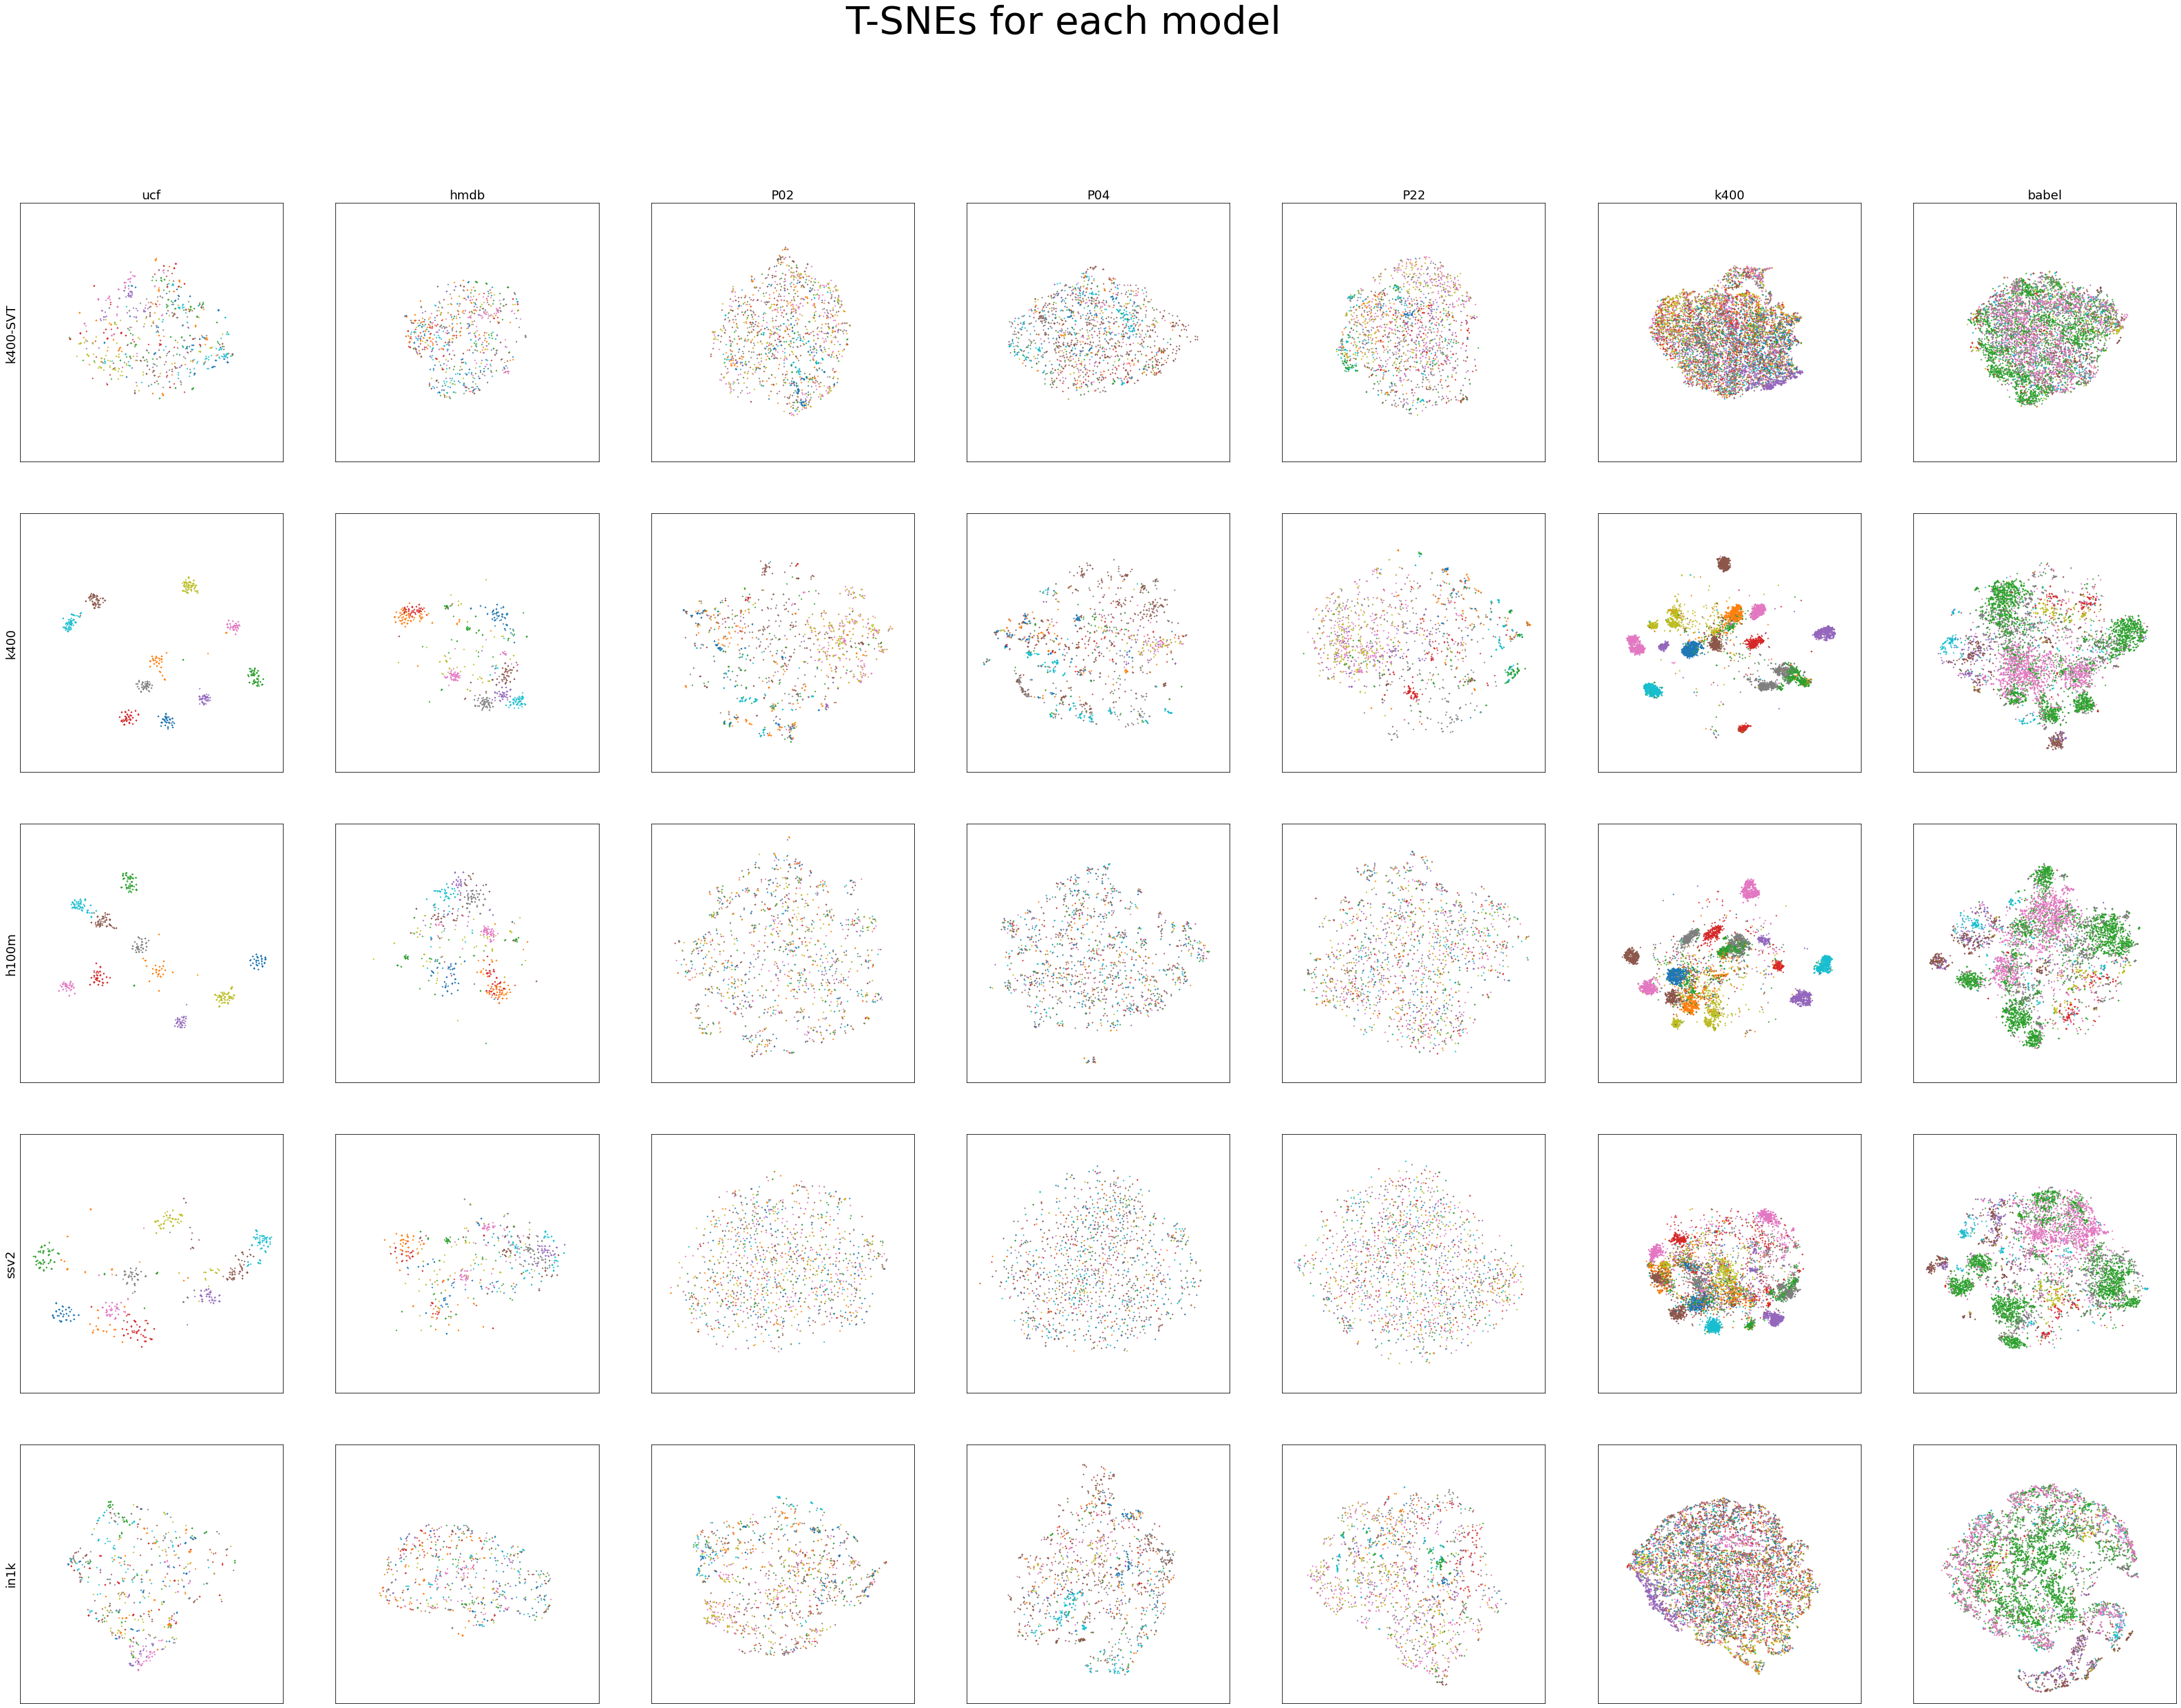

In [11]:
n_rows = len(weights)
n_cols = len(real_dataset_name_mapping)
scale = 8
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(scale*n_cols, scale*n_rows))
keys = ['bottom', 'top', 'left', 'right']
options = {
    'axis': 'both', 'which': 'both',
    **{key: False for key in keys},
    **{f'label{key}': False for key in keys}
}
all_subtasks = np.array(sum(map(list, tasks.values()), []))
idx_tsne = 0
for i, axes_row in enumerate(axes):
    for j, ax in enumerate(axes_row):
        ax.tick_params(**options)
        subtask = all_subtasks[j]
        task, = [task for task, subtasks in tasks.items() if subtask in subtasks]
        if i == 0: ax.set_title(subtask, fontsize=18)
        if j == 0: ax.set_ylabel(weights[i], fontsize=18)
        tsne = tsnes[idx_tsne]
        ann_train = ann_trains[idx_tsne]
        idx_tsne += 1
        if ann_train is None:
            continue
        num_old, num_new = num_classes[task]
        for l in range(num_old):
            ax.scatter(*tsne[ann_train==l].T, s=3, alpha=0)
        for l in range(num_old, num_old+num_new):
            ax.scatter(*tsne[ann_train==l].T, s=1, marker='x')
        # for l in range(ann_train.max()+1):
        #     ax.scatter(*tsne[ann_train==l].T, s=1)
fig.suptitle('T-SNEs for each model', fontsize=56)
plt.show()